In [1]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline
# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import json
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import random
import json
import statsmodels.graphics.tsaplots as tsaplots
import pymc as pm

In [2]:
# from pyquery import PyQuery as pq
from bs4 import BeautifulSoup
# The "requests" library makes working with HTTP requests easier
# than the built-in urllib libraries.
import requests
from datetime import datetime
from dateutil import parser
from collections import Counter
from itertools import groupby

In [38]:
movies_reviewed = {}

try:
    page=requests.get("http://www.rottentomatoes.com/user/id/780849123/ratings")
    soup = BeautifulSoup(page.text, "html.parser")

    page_reviews = soup.find_all("div", attrs={"class":"panel-body content_body"})
    movie = page_reviews[3].find_all("div", attrs={"class":"media-body"})
    num_movie = 0
    for m in movie:
        #Check get the number of stars
        stars = m.find_all("span", attrs ={"class":"glyphicon glyphicon-star"})
        movie_page = requests.get("http://www.rottentomatoes.com/" + m.find("div", attrs={"class":"media-heading"}).find("a").get("href"))
        soup = BeautifulSoup(movie_page.text, "html.parser")
        genres = soup.find_all("span", attrs={"itemprop":"genre"})
        for g in genres:
            if g.get_text() not in movies_reviewed.keys():
                movies_reviewed[g.get_text()] = len(stars)
            else:
                movies_reviewed[g.get_text()] = np.hstack((movies_reviewed[g.get_text()], len(stars)))
        num_movie += 1
    
        if num_movie % 100 == 0:
            print num_movie
        
        if num_movie >= 300:
            break
        
except Exception as e:
    print "Exception"

100
200
300


In [50]:
data_save = {}
for k in movies_reviewed:
    data_save[k] = list(movies_reviewed[k])

In [53]:
with open('one_user_data.json', 'w') as fp:
    json.dump(data_save,fp)

In [3]:
with open('one_user_data.json') as data_file: 
    all_genres = json.load(data_file)

In [21]:
dict_keys = all_genres.keys()
dict_keys
numgenres = len(dict_keys)

In [71]:
print np.max(all_genres[dict_keys[3]])
print all_genres[dict_keys[3]]

5
[3, 2, 4, 2, 4, 3, 3, 3, 3, 2, 2, 4, 3, 4, 4, 3, 3, 4, 2, 3, 2, 3, 3, 3, 3, 5, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 1, 2, 3, 3, 3, 1, 4, 2, 2, 2, 4, 3, 3, 3, 3, 3, 3, 3, 2, 2, 4, 3, 2, 3, 4, 2, 2, 3, 3, 3, 3, 2, 2, 1, 2, 4, 2, 3, 4, 3, 2, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 4]


In [29]:
rating_dist = np.zeros((numgenres,6))
for movieindx in np.arange(numgenres):
    rating_dist[movieindx,:] = np.bincount(all_genres[dict_keys[movieindx]],minlength=6)
print rating_dist[0]
print sum(rating_dist[0])

[ 1.  0.  7.  5.  2.  0.]
15.0


In [81]:
## Define function to calculate posterior

#def posterior_pratings(alphapara,numeachrating,numvotes, samples=100000):
def posterior_pratings(alphapara,all_data,numvotes, samples=100000):
    #The prior for the rate parameter
    #priorpupvote = pm.Beta("priorpupvote", alphapara, betapara)
    ratings_prior = pm.CompletedDirichlet("ratings_prior",pm.Dirichlet("priorratings",alphapara))
#    ratings_prior = pm.Uniform()
#     @pm.deterministic 
#     def pratings(a=ratings_prior):
#         print a
#         return a    
#     #likelihood = pm.Multinomial('likelihood', p=pratings, n=numvotes, value=numeachrating, observed=True)
    @pm.observed
    def getloglike(pr = ratings_prior,value=all_data):
        loglikelihood = 0
        
        for voteindx in range(numvotes):
            data = np.zeros(6)
            data[value[voteindx]]=1
            loglikelihood += pm.multinomial_like(data,1,pr) 
                
        return loglikelihood

    popularity_model=pm.Model([ratings_prior, getloglike])
    mcmc = pm.MCMC(popularity_model)     
    mcmc.sample(iter=samples, burn=samples / 4, thin=2)
    return mcmc

In [82]:
alpha = np.array([1,1,1,1,1,1])
print all_genres[dict_keys[3]][91]
#mcmc_genre1 = posterior_pratings(alpha,rating_dist[3],sum(rating_dist[3]))
#mcmc_genre1 = posterior_pratings(alpha,[100,10],110)
mcmc_genre1 = posterior_pratings(alpha,all_genres[dict_keys[3]],len(all_genres[dict_keys[3]]))
print  all_genres[dict_keys[3]]

4
 [-----------------100%-----------------] 100000 of 100000 complete in 0.6 sec[3, 2, 4, 2, 4, 3, 3, 3, 3, 2, 2, 4, 3, 4, 4, 3, 3, 4, 2, 3, 2, 3, 3, 3, 3, 5, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 1, 2, 3, 3, 3, 1, 4, 2, 2, 2, 4, 3, 3, 3, 3, 3, 3, 3, 2, 2, 4, 3, 2, 3, 4, 2, 2, 3, 3, 3, 3, 2, 2, 1, 2, 4, 2, 3, 4, 3, 2, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 4]


C:\Users\Yipei\Anaconda2\lib\site-packages\ipykernel\__main__.py:19: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Plotting ratings_prior_0_0
Plotting ratings_prior_0_1
Plotting ratings_prior_0_2
Plotting ratings_prior_0_3
Plotting ratings_prior_0_4
Plotting ratings_prior_0_5


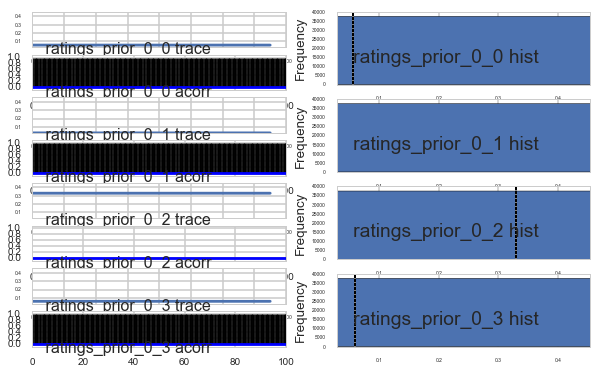

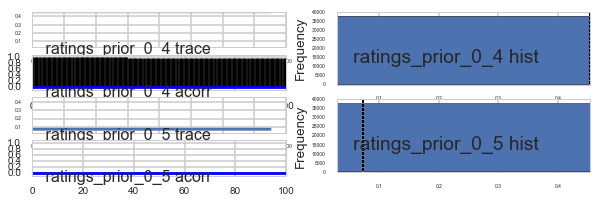

In [88]:
pm.Matplot.plot(mcmc_genre1.trace('ratings_prior'))

#print rating_dist[3]
#print sum(rating_dist[3])